In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [ ]:
import os
import pickle
import string
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import add
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.preprocessing.image import img_to_array, load_img
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# **Extract features from the images using VGG16**

## **VGG16**

VGG16 is a deep convolutional neural network model that is used for image classification and image recognition tasks. The network is composed of 16 layers of artificial neurons that have weights. It is considered one of the best computer vision model architectures to date.

Instead of having a large number of hyper-parameters, VGG16 uses convolution layers with a 3x3 filter and a stride 1 that are in the same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has two fully connected layers, followed by a softmax for output.

In VGG16, "VGG" refers to the Visual Geometry Group of the University of Oxford, while the "16" refers to the network's 16 layers that have weights. This network is a pretty large network, and it has about 138 million parameters.

VGG16 is used for image recognition and classification in new images. The pre-trained version of the VGG16 network is trained on over one million images from the ImageNet visual database, and is able to classify images into 1,000 different categories with 92.7 percent top-5 test accuracy. VGG16 can be applied to determine whether an image contains certain items, animals, plants and more.

To learn more about VGG16 check this link: https://builtin.com/machine-learning/vgg16

In [ ]:
def extract_features(directory):
    model = VGG16() # A pre-trained CNN architecture used for image recognition
    model.layers.pop() # Removes the last layer (output layer) from the VGG16 model --> Extract features from the images using the intermediate
                       # layers of the model, rather than using the final classification layer, so that it can be used as a feature extractor
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output) # output -> second-to-last layer of VGG16 model, outputs the features
                                                                            # extracted by the VGG16 model
    print(model.summary())
    features = {}
    i = 0
    for name in os.listdir(directory):
        print(i)
        img = load_img(directory + '/' + name, target_size = (224, 224))
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        feature = model.predict(img, verbose = 0)
        img_id = name.split('.')[0]
        features[img_id] = feature
        i += 1
    return features

directory = '/content/drive/MyDrive/Image Captioning/Flicker8k/Flicker8k_Dataset'
features = extract_features(directory)
pickle.dump(features, open('/content/drive/MyDrive/Image Captioning/features.pkl', 'wb'))

# **Load, Clean and Save image descriptions**

In [ ]:
# Returns a dictionary with image_id as keys and respective list of descriptions as values
def load_description(filename):
    mappings = {}
    file = open(filename, 'r')
    content = file.readlines()
    file.close()
    for lines in content:
        tokens = lines.split()
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0].split('.')[0], tokens[1:]
        image_desc = ' '.join(image_desc)
        if image_id not in mappings:
            mappings[image_id] = []
        mappings[image_id].append(image_desc)
    return mappings

# Cleans the descriptions by converting the text to lowercase, removing punctuation, and retaining only alphabetic characters
def clean_description(descriptions):
    table = str.maketrans('', '', string.punctuation) # str.maketrans(old, new, delete) -> creates a translation table that can be used to remove
                                                      # punctuations from the string
    for image_id, image_descriptions in descriptions.items():
        for i in range(len(image_descriptions)):
            desc = image_descriptions[i]
            desc = desc.split()
            desc = [x.lower() for x in desc]
            desc = [w.translate(table) for w in desc]
            desc = [x for x in desc if len(x) > 1]
            desc = [x for x in desc if x.isalpha()]
            image_descriptions[i] = ' '.join(desc)

# Creates a corpus(set) of all words from the descriptions
def create_corpus(descriptions):
    corpus = set()
    for k in descriptions.keys():
        [corpus.update(x.split()) for x in descriptions[k]]
    return corpus

# Saves the cleaned descriptions into a file in the same format as the token file
def save_descriptions(desc, filename):
    lines = []
    for image_id, descriptions in desc.items():
        for description in descriptions:
            lines.append(image_id + ' ' + description)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# Load all descriptions from token file
filename = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flickr8k.token.txt'
descriptions = load_description(filename)
print('Descriptions loaded: ', len(descriptions))

# Clean the loaded descriptions
clean_description(descriptions)

# Check the vocabulary length
vocabulary = create_corpus(descriptions)
print('Vocabulary length: ', len(vocabulary))

# Save the descriptions
save_descriptions(descriptions, '/content/drive/MyDrive/ImageCaptioning/descriptions.txt')

print('SAVED !!!')

Descriptions loaded:  8092
Vocabulary length:  8763
SAVED !!!


# **Load Train and Test image features and descriptions**

In [ ]:
# Returns a set of image_ids from the trainImages/testImages file
def load_set_of_image_ids(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    file.close()
    image_ids = set()
    for line in lines:
        if len(line) < 1:
            continue
        image_ids.add(line.split('.')[0])
    return image_ids

# Returns a dictionary of image_ids and their descriptions list for train/test images from the descriptions file
def load_clean_descriptions(all_desc, image_ids):
    file = open(all_desc, 'r')
    lines = file.readlines()
    descriptions = {}
    for line in lines:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in image_ids:
            if image_id not in descriptions:
                descriptions[image_id] = []
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

# Returns a dictionary of image_ids and their corresponding features for train/test images from the features file
def load_image_features(filename, dataset):
    all_features = pickle.load(open(filename, 'rb'))
    features = {image_id:all_features[image_id] for image_id in dataset}
    return features

# Load train image ids
train_images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flickr_8k.trainImages.txt'
train_image_ids = load_set_of_image_ids(train_images)
print('Training images found: ', len(train_image_ids))

# Load training descriptions
descriptions = '/content/drive/MyDrive/ImageCaptioning/descriptions.txt'
train_descriptions = load_clean_descriptions(descriptions, train_image_ids)
print('Training descriptions loaded: ', len(train_descriptions))

# Load training image features
features = '/content/drive/MyDrive/ImageCaptioning/features.pkl'
train_features = load_image_features(features, train_image_ids)
print('Training features loaded: ', len(train_features))

# train_descriptions

Training images found:  6000
Training descriptions loaded:  6000
Training features loaded:  6000


# **Get descriptions in shape**

In [ ]:
# Stores all train descriptions in a list
def to_list(descriptions):
    all_desc_list = []
    for image_id, image_desc in descriptions.items():
        for desc in image_desc:
            all_desc_list.append(desc)
    return all_desc_list

def tokenization(descriptions):
    all_desc_list = to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc_list)
    return tokenizer

# Create tokenizer
tokenizer = tokenization(train_descriptions)

# Length of the unique words in the train descriptions
vocab_size = len(tokenizer.word_index)+1 # word_index is the dictionary of {word: integer}, integer starting from 1
print('Vocab size: ', vocab_size)

# Returns maximum length (no. of words in a description) out of all the descriptions
def max_length(descriptions):
    all_desc_list = to_list(descriptions)
    return max(len(x.split()) for x in all_desc_list)

max_len = max_length(train_descriptions)
print(max_len)

Vocab size:  7579
34


# **Functions to generate data and create a model**

In [ ]:
def create_sequences(tokenizer, desc_list, max_len, photo):
    x1, x2, y = [], [], [] # x1 will contain photo, x2 will contain current sequence, y will contain one hot encoded next word
    for desc in desc_list:
        # Tokenize descriptions
        seq = tokenizer.texts_to_sequences([desc])[0] # list of numbers for each word in the description
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i] # out_seq is the next word in the sentence
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen = max_len)[0] # Pads the input sequence with zeros at the beginning to match the max_length
            # One-hot encode output sequence
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] # A vector of size vocab_size with 1 at the out_seq index and 0 elsewhere
            x1.append(photo)
            x2.append(in_seq)
            y.append(out_seq)
    return np.array(x1), np.array(x2), np.array(y)

def data_generator(descriptions, photos, tokenizer, max_len):
    while 1:
        for image_id, desc_list in descriptions.items():
            photo = photos[image_id][0]
            in_img, in_seq, out_seq = create_sequences(tokenizer, desc_list, max_len, photo)
            yield[[in_img, in_seq], out_seq] # The yield keyword is used to return a list of values from a function. Unlike the return keyword
                                             # which stops further execution of the function, the yield keyword continues to the end of the function

def define_model(vocab_size, max_length):
    # Image features extractor model
    inputs1 = Input(shape = (1000,))
    fe1 = Dropout(0.5)(inputs1) # Dropout -> regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting
    fe2 = Dense(256, activation = 'relu')(fe1)

    # Input sequence model
    inputs2 = Input(shape = (max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2) # Embedding(input_dim, output_dim), input_dim is always the vocab_size
                                                                # output_dim tells the size of vector space in which the words will be embedded
                                                                # mask_zero is used when the input itself is 0, then to not confuse it with padded
                                                                # zeros, it is set as True
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder model or Output word model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    # Summarize model
    print(model.summary())
    return model

# **Creating and training the Image Captioning model**

In [ ]:
model = define_model(vocab_size, max_len)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_len)
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    model.save('/content/drive/MyDrive/ImageCaptioning/models/model_' + str(i) + '.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              1940224   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1000)                 0         ['input_1[0][0]']             
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6000/6000 [==============================] - 1505s 251ms/step - loss: 2.5964


# **Prediction and Evaluation functions for the Image Captioning model**

In [ ]:
def int2word(tokenizer, integer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Returns the predicted description for the given image using its features
def predict_desc(model, tokenizer, photo, max_len):
    in_seq = 'startseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_seq])[0]
        seq = pad_sequences([seq], maxlen = max_len)
        y_hat = model.predict([photo, seq], verbose = 0)
        y_hat = np.argmax(y_hat) # Returns the index of the maximum value
        word = int2word(tokenizer, y_hat)
        if word == None:
            break
        in_seq = in_seq + ' ' + word
        if word == 'endseq':
            break
    return in_seq

def evaluate_model(model, descriptions, photos, tokenizer, max_len):
    actual, predicted = [], [] # Stores actual and predicted descriptions
    for image_id, image_desc in descriptions.items():
        y_hat = predict_desc(model, tokenizer, photos[image_id], max_len) # Predicted sequence(description) for the image
        references = [desc.split() for desc in image_desc]
        actual.append(references)
        predicted.append(y_hat.split())
    print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0))) # corpus_bleu(reference translations, machine-generated translation)
    print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))
    print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights = (0.33, 0.33, 0.33, 0)))
    print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights = (0.25, 0.25, 0.25, 0.25)))

    # BLEU - Bilingual Evaluation Understudy --> provides a numerical score that represents the similarity between the machine-generated translations
    # and the reference translations, with higher scores indicating better translation quality
    # sentence_bleu --> used to compute the BLEU score for a single translated sentence
    # corpus_bleu --> used to compute the BLEU score for an entire corpus of translations

# **Evaluating Image Captioning model**

In [ ]:
# Load train image_ids
train_images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flickr_8k.trainImages.txt'
train_image_ids = load_set_of_image_ids(train_images)
print('Training images found: ', len(train_image_ids))

# Load training descriptions
descriptions = '/content/drive/MyDrive/ImageCaptioning/descriptions.txt'
train_descriptions = load_clean_descriptions(descriptions, train_image_ids)
print('Training descriptions loaded: ', len(train_descriptions))

# Load training image features
features = '/content/drive/MyDrive/ImageCaptioning/features.pkl'
train_features = load_image_features(features, train_image_ids)
print('Training features loaded: ', len(train_features))

tokenizer = tokenization(train_descriptions)
max_len = max_length(train_descriptions)

# Load test image_ids
test_images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flickr_8k.testImages.txt'
test_image_ids = load_set_of_image_ids(test_images)
print('Test images found: ', len(test_image_ids))

# Load test descriptions
test_descriptions = load_clean_descriptions(descriptions, test_image_ids)
print('Test descriptions loaded: ', len(test_descriptions))

# Load test image features
test_features = load_image_features(features, test_image_ids)
print('Test features loaded: ', len(test_features))

filename = '/content/drive/MyDrive/ImageCaptioning/best_model.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_len)

Training images found:  6000
Training descriptions loaded:  6000
Training features loaded:  6000
Test images found:  1000
Test descriptions loaded:  1000
Test features loaded:  1000
BLEU-1: 0.516453
BLEU-1: 0.272898
BLEU-1: 0.162429
BLEU-1: 0.092434


# **Live Image Captioning**


dog runs through the grass


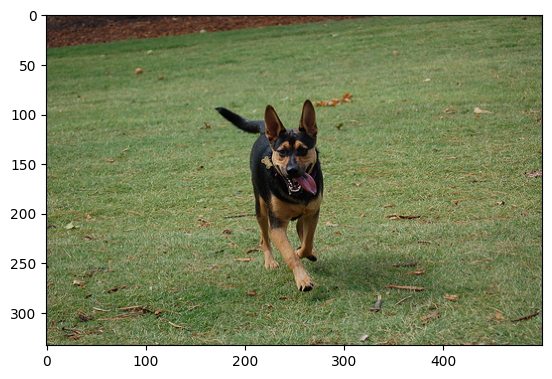

In [ ]:
img_to_test = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flicker8k_Dataset/697582336_601462e052.jpg'
img = plt.imread(img_to_test)
plt.imshow(img)

def extract_features(filename):
    # Load the model
    model = VGG16()
    # Re-structure the model
    model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    # Load the photo
    image = load_img(filename, target_size = (224, 224))
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the VGG model
    image = preprocess_input(image)
    # Get features
    feature = model.predict(image, verbose = 0)
    return feature

# Pre-define the max sequence length (from training)
max_len = max_length(train_descriptions)
# Load the model
model = load_model('/content/drive/MyDrive/ImageCaptioning/best_model.h5')
# Load and prepare the photograph
photo = extract_features(img_to_test)
# Generate description
description = predict_desc(model, tokenizer, photo, max_len)

description = ' '.join(description.split()[1:-1])
print()
print(description)

# **Streamlit UI**

In [ ]:
# @title Setup code
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
# import subprocess
# subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
--2024-05-10 12:47:49--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2024.4.1/cloudflared-linux-amd64 [following]
--2024-05-10 12:47:49--  https://github.com/cloudflare/cloudflared/releases/download/2024.4.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting resp

In [ ]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://slovak-ground-colin-trailer.trycloudflare.com


In [ ]:
!streamlit run /content/drive/MyDrive/ImageCaptioning/app.py &>/content/logs.txt &

In [ ]:
%%writefile /content/drive/MyDrive/ImageCaptioning/app.py

import streamlit as st
import numpy as np
import tensorflow
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img

# Returns a set of image_ids from the trainImages/testImages file
def load_set_of_image_ids(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    file.close()
    image_ids = set()
    for line in lines:
        if len(line) < 1:
            continue
        image_ids.add(line.split('.')[0])
    return image_ids

# Returns a dictionary of image_ids and their descriptions list for train/test images from the descriptions file
def load_clean_descriptions(all_desc, image_ids):
    file = open(all_desc, 'r')
    lines = file.readlines()
    descriptions = {}
    for line in lines:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in image_ids:
            if image_id not in descriptions:
                descriptions[image_id] = []
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

# Stores all train descriptions in a list
def to_list(descriptions):
    all_desc_list = []
    for image_id, image_desc in descriptions.items():
        for desc in image_desc:
            all_desc_list.append(desc)
    return all_desc_list

def tokenization(descriptions):
    all_desc_list = to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc_list)
    return tokenizer

# Returns maximum length (no. of words in a description) out of all the descriptions
def max_length(descriptions):
    all_desc_list = to_list(descriptions)
    return max(len(x.split()) for x in all_desc_list)

def int2word(tokenizer, integer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Returns the predicted description for the given image using its features
def predict_desc(model, tokenizer, photo, max_len):
    in_seq = 'startseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_seq])[0]
        seq = pad_sequences([seq], maxlen = max_len)
        y_hat = model.predict([photo, seq], verbose = 0)
        y_hat = np.argmax(y_hat) # Returns the index of the maximum value
        word = int2word(tokenizer, y_hat)
        if word == None:
            break
        in_seq = in_seq + ' ' + word
        if word == 'endseq':
            break
    return in_seq

def extract_features(filename):
    # Load the model
    model = VGG16()
    # Re-structure the model
    model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    # Load the photo
    image = load_img(filename, target_size = (224, 224))
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the VGG model
    image = preprocess_input(image)
    # Get features
    feature = model.predict(image, verbose = 0)
    return feature

# Load train image_ids
train_images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k/Flickr_8k.trainImages.txt'
train_image_ids = load_set_of_image_ids(train_images)

# Load training descriptions
descriptions = '/content/drive/MyDrive/ImageCaptioning/descriptions.txt'
train_descriptions = load_clean_descriptions(descriptions, train_image_ids)

tokenizer = tokenization(train_descriptions)

# Pre-define the max sequence length (from training)
max_len = max_length(train_descriptions)

# Load the model
model = load_model('/content/drive/MyDrive/ImageCaptioning/best_model.h5')

st.title("Image Caption Generator")
st.markdown("Upload image to generate caption...")
image = st.file_uploader("Choose an image")
if image is not None:
    st.image(image)
    # Load and prepare the photograph
    photo = extract_features(image)
    # Generate description
    description = predict_desc(model, tokenizer, photo, max_len)
    description = ' '.join(description.split()[1:-1])
    st.write(description)

Overwriting /content/drive/MyDrive/ImageCaptioning/app.py


In [ ]:
!streamlit run /content/drive/MyDrive/ImageCaptioning/app.py &>/content/logs.txt & npx localtunnel --port 8000 & curl ipv4.icanhazip.com

34.73.122.239
npx: installed 22 in 3.813s
your url is: https://dry-days-fall.loca.lt
